# MultiLingual Named Entity Recognition

## Background

What happens when you want to fine tune a model on less popular dataset or your 
corpus contains text in different languages? For such tasks, some transformers has already been pretrained on a corpus with 100s of languages which enable zeroshot crosslingual transfer learning. An eample of such model is XLM_RoBERTa 
and we will use it to tackle a multilingual NER task in this notebook.

The goal of this notebook is to perform NER for a customer based in
Switzerland, where there are four national languages (with English often serving as a bridge between them).

#### Install The Required Modules For This Task

In [ ]:
!pip install -qq transformers
!pip install -qq datasets
!pip install -qq seqeval

#### Getting The Dataset.

We will use a subset of xtreme called pan-x where entiies are annotated with the IOB2 format. The four most
commonly spoken languages in Switzerland: German (62.9%), French (22.9%),Italian
(8.4%), and English (5.9%). We will try replicate these percentages for our task.

In [ ]:
from datasets import get_dataset_config_names # to get config names in xtreme
from datasets import load_dataset # loading datasets from hugging face

xtreme_subsets = get_dataset_config_names('xtreme')  # configurations in xtreme
print(f'Xtreme has {len(xtreme_subsets)} different configurations')
pan_configs = [s for s in xtreme_subsets if s.startswith('PAN')]  ## see patterns of xtreme pan configuration
print(pan_configs[: 3])

Xtreme has 183 different configurations
['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']


In [ ]:
from collections import defaultdict
from datasets import DatasetDict
import pandas as pd

# simulate real world data where getting examples of popular class is expensive
langs = ['de', 'fr', 'it', 'en']
fracs = [0.629, 0.229, 0.084, 0.059]

panx_ch = defaultdict(DatasetDict)  # stores language code as key and DatasetDict as value
for lang, frac in zip(langs, fracs):
  ds = load_dataset('xtreme', name = f'PAN-X.{lang}') # load a monolingual corpus
  for split in ds:
    panx_ch[lang][split] = (ds[split].shuffle(seed = 0).
                            select(range(int(frac* ds[split].num_rows))))  # sample to frac needed

pd.DataFrame({lang: [panx_ch[lang]["train"].num_rows]for lang in langs},   # see number of train samples per subset
             index = ['Number of training examples'])

Reusing dataset xtreme (/root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-895dfb6c4273b2e5.arrow
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-441068b3ea7cbef3.arrow
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-1ec023bbd4560444.arrow
Reusing dataset xtreme (/root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-c99e2d963e99c3bc.arrow
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-95d424970390df95.arrow
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-c8f8d90ec625373b.arrow
Reusing dataset xtreme (/root/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-127e932015d0d753.arrow
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-f7bdfc2c46f67b82.arrow
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-affab8fcf3f5bef3.arrow
Reusing dataset xtreme (/root/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-739f170d5471f1cb.arrow
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-3e10f730fe826b06.arrow
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-5314845d936312dc.arrow


,de,fr,it,en
Number of training examples,12580,4580,1680,1180


In [ ]:
# inspect a single example in the german train data
element = panx_ch['de']['train'][0]
for key, value in element.items():
  print(f'{key}: {value}')

for key, value in panx_ch['de']['train'].features.items():  ## see the class mappings
  print(f'{key}: {value}')

tokens: ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der', 'polnischen', 'Woiwodschaft', 'Pommern', '.']
ner_tags: [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
langs: ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']
tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [ ]:
# create a new column with class name for each tag using Classname.int2str

tags = panx_ch["de"]["train"].features["ner_tags"].feature
def create_tag_names(batch):
  return {'ner_tags_str' : [tags.int2str(idx) for idx in batch['ner_tags']]}

panx_de = panx_ch['de'].map(create_tag_names)

de_example = panx_de['train'][0]
pd.DataFrame([de_example['tokens'], de_example['ner_tags_str']], ['Tokens', 'Tags'])

Parameter 'function'=<function create_tag_names at 0x7f925425f440> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/12580 [00:00<?, ?ex/s]

  0%|          | 0/6290 [00:00<?, ?ex/s]

  0%|          | 0/6290 [00:00<?, ?ex/s]

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


In [ ]:
# count the number of each entity in the train set to ensure balance
from collections import Counter

split2freqs = defaultdict(Counter)
for split, dataset in panx_de.items():
  for row in dataset['ner_tags_str']:
    for tag in row:
      if tag.startswith('B'):
        tag_type = tag.split('-')[1]
        split2freqs[split][tag_type] += 1
pd.DataFrame.from_dict(split2freqs, orient="index")

,LOC,ORG,PER
train,6186,5366,5810
validation,3172,2683,2893
test,3180,2573,3071


#### MultiLingual Transformers: A close look at tokenizer
For this task, we will use XLM-R- a version of Roberta used for cross lingual transfer with main differences in the tokenization approach and vocab size

In [ ]:
## see how SentencePiece which XLM-R uses differs from piece
from transformers import AutoTokenizer

bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)  # initialize bert tokenizer
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)  # initialize roberta tokenizer

text = "Jack Sparrow loves New York!"   # text to tokenize
bert_tokens = bert_tokenizer(text).tokens()   # get bert tokens for text
xlmr_tokens = xlmr_tokenizer(text).tokens()   # get roberta tokens for text
print(bert_tokens)
print(xlmr_tokens)

['[CLS]', 'Jack', 'Spa', '##rrow', 'loves', 'New', 'York', '!', '[SEP]']
['<s>', '▁Jack', '▁Spar', 'row', '▁love', 's', '▁New', '▁York', '!', '</s>']


#### Creating a Custom Model for Token Classification

For this task, we would build a custom token classification head. Note that Hugging Face already has an XLMRobertaForTokenClassification class. The goal here to learn how to build heads for our custom tasks that does not exist yet.

In [ ]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
  def __init__(self, config):
    super().__init__(config)
    self.num_labels = config.num_labels
    self.roberta = RobertaModel(config, add_pooling_layer=False) # model body
    self.dropout = nn.Dropout(config.hidden_dropout_prob)
    self.classifier = nn.Linear(config.hidden_size, config.num_labels) # token classification head
    self.init_weights()  # initialize weights

  def forward(self, input_ids=None, attention_mask=None, token_type_ids=None,
              labels=None, **kwargs):
    outputs = self.roberta(input_ids, attention_mask=attention_mask,
                       token_type_ids=token_type_ids, **kwargs)     # get encoder hidden states
    sequence_output = self.dropout(outputs[0])
    logits = self.classifier(sequence_output)
    # calculate loss
    loss = None
    if labels is not None:
      loss_fct = nn.CrossEntropyLoss()
      loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

    return TokenClassifierOutput(loss=loss, logits=logits,
                                 hidden_states=outputs.hidden_states,
                                 attentions=outputs.attentions)



#### Loading The Custom Model


In [ ]:
from transformers import AutoConfig
import torch

index2tag = {idx: tag for idx, tag in enumerate(tags.names)}   # index mappings of labels to pass to autoconfig
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}    # name mappings of labels to pass to autoconfig


xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,
                                         num_labels = tags.num_classes,
                                         id2label = index2tag, label2id = tag2index) # overiding the original config files

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # check if gpu is available and use it to load model

xlmr_model = (XLMRobertaForTokenClassification.from_pretrained(xlmr_model_name,
                                                               config = xlmr_config).to(device)) # initialize token classification model

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'classif

In [ ]:
# check if things are working fine
input_ids = xlmr_tokenizer.encode(text, return_tensors = 'pt')
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Input IDs"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


In [ ]:
# pass input ids to model and extract predictions
outputs =xlmr_model(input_ids = input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim=-1)

print(f"Number of tokens in sequence: {len(xlmr_tokens)}")
print(f"Shape of outputs: {outputs.shape}")

# see dataframe presentation of tokens
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"])

Number of tokens in sequence: 10
Shape of outputs: torch.Size([1, 10, 7])


,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC


In [ ]:
# create helper functions that performs the two tasks above
def tag_text(text, tags, model, tokenizer):
  tokens = tokenizer(text).tokens() # get tokens
  input_ids = tokenizer(text, return_tensors = 'pt').input_ids.to(device) # encode sequence to ids
  outputs = model(input_ids)[0]  # get logits over 7 classes
  predictions = torch.argmax(outputs, dim=2)  # get class prediction
  preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
  return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])

#### Tokenizing Texts for NER
The goal here is to prepare the inputs and labels in the best form for ner task.

In [ ]:
## see example with german text
words, labels = de_example['tokens'], de_example['ner_tags']
tokenized_input = xlmr_tokenizer(de_example["tokens"], is_split_into_words=True) # tokenize texts noting that its already split to words
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input['input_ids']) 
pd.DataFrame([tokens], index=["Tokens"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


In [ ]:
word_ids = tokenized_input.word_ids()  # get word ids that allow using the IOB2 format
pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


Need a way to make sure our labels has the same size as the number of tokens. We will label tokens we are not interested in with -100. This is because cross_entropy loss ignores such labels during training.


In [ ]:
previous_word_idx = None  #initialize previous word to none
label_ids = []    # list of label_ids
for word_idx in word_ids:
  if word_idx is None or word_idx == previous_word_idx: #append label with -100 for tokens we want to ignore
    label_ids.append(-100)
  elif word_idx != previous_word_idx:  # for main tokens append with the proper label in IOB2 format
    label_ids.append(labels[word_idx])
  previous_word_idx = word_idx
labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]  # update label mappings
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]
pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


In [ ]:
## build a function that scales the insights above to the whole dataset
def tokenize_and_align_labels(examples):
  tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True,
                                    is_split_into_words=True)
  labels = []
  for idx, label in enumerate(examples["ner_tags"]):
    word_ids = tokenized_inputs.word_ids(batch_index=idx)
    previous_word_idx = None
    label_ids = []
    for word_idx in word_ids:
      if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
      else:
        label_ids.append(label[word_idx])
      previous_word_idx = word_idx
    labels.append(label_ids)
  tokenized_inputs["labels"] = labels
  return tokenized_inputs

# encode splits across datasets
def encode_panx_dataset(corpus):
  return corpus.map(tokenize_and_align_labels, batched=True,
                    remove_columns=['langs', 'ner_tags', 'tokens'])

In [ ]:
## enocode the german corpus
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

  0%|          | 0/13 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

#### Performance Measures
The drawback of using f1-score/accuracy score directly for this task is that all predictions within a single sequence must be correct for that example to be accurate. What we want is to measure in sequence accuracy/f1-score. That way the total accuracy will be the averge accuracy over all examples. There is a library called seqeval that makes such evaluation easy. Lets explore it 

In [ ]:
from seqeval.metrics import classification_report

y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],    # expects predictions and labels as list of list, each  
          ["B-PER", "I-PER", "O"]]                              # each list corresponds to a single example
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [ ]:
import numpy as np
from seqeval.metrics import f1_score

## function to align predictions
# expects a list of list like seqeval would
def align_predictions(predictions, label_ids):
  preds = np.argmax(predictions, axis=2) # take arg_max
  batch_size, seq_len = preds.shape
  labels_list, preds_list = [], []     # initialize and empty label and preds list
  for batch_idx in range(batch_size):   #for each example
    example_labels, example_preds = [], []   # initialize labels and preds for that example
    for seq_idx in range(seq_len):            # for each classification in that example
      if label_ids[batch_idx, seq_idx] != -100:    # Ignore label IDs = -100
        example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
        example_preds.append(index2tag[preds[batch_idx][seq_idx]])
    labels_list.append(example_labels)                   # update labels now list of list
    preds_list.append(example_preds)                   # update preds also list of list
  return preds_list, labels_list

# function to evaluate model
def compute_metrics(eval_pred):
  y_pred, y_true = align_predictions(eval_pred.predictions,
                                     eval_pred.label_ids)
  return {"f1": f1_score(y_true, y_pred)}

#### Fine-Tuning XLM-RoBERTa

Lets first fine tune on the german texts and evaluate on english, french and italian

In [ ]:
from transformers import TrainingArguments

# define training args
num_epochs = 3
batch_size = 16
logging_steps = len(panx_de_encoded["train"]) // batch_size
model_name = f'{xlmr_model_name}-finetune-panx-de'

training_args = TrainingArguments(output_dir = model_name,log_level = 'error',
                                  num_train_epochs= num_epochs,
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size = batch_size,
                                  evaluation_strategy="epoch",
                                  save_steps=1e6, weight_decay=0.01, disable_tqdm=False,
                                  logging_steps=logging_steps, push_to_hub=True)

In [ ]:
# # login into hub and save model
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [ ]:
# create a datacollator, it batchs our train data 
# hugging face also has a specific datacollator that pads sequence along with labels
# labels are padded with -100 so ignored
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [ ]:
## initialize model
def model_init():
  return (XLMRobertaForTokenClassification
          .from_pretrained(xlmr_model_name, config=xlmr_config)
          .to(device))

In [ ]:
# initialize trainer
from transformers import Trainer
trainer = Trainer(model_init=model_init, args=training_args,
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  train_dataset=panx_de_encoded["train"],
                  eval_dataset=panx_de_encoded["validation"],
                  tokenizer=xlmr_tokenizer)

Cloning https://huggingface.co/okite97/xlm-roberta-base-finetune-panx-de into local empty directory.


In [ ]:
# train
trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,F1
1,0.254200,0.178832,0.808334
2,0.130700,0.137075,0.848787
3,0.078400,0.140473,0.861144


Adding files tracked by Git LFS: ['tokenizer.json']. This may take a bit of time if the files are large.


Upload file pytorch_model.bin:   0%|          | 3.33k/1.03G [00:00<?, ?B/s]

Upload file training_args.bin: 100%|##########| 3.23k/3.23k [00:00<?, ?B/s]

Upload file tokenizer.json:   0%|          | 3.34k/16.3M [00:00<?, ?B/s]

Upload file runs/Jul09_02-03-55_5352cdc921bd/events.out.tfevents.1657332281.5352cdc921bd.864.0:  60%|#####9   …

Upload file runs/Jul09_02-03-55_5352cdc921bd/1657332281.3015409/events.out.tfevents.1657332281.5352cdc921bd.86…

To https://huggingface.co/okite97/xlm-roberta-base-finetune-panx-de
   a6be12a..9131e30  main -> main

To https://huggingface.co/okite97/xlm-roberta-base-finetune-panx-de
   9131e30..a7695d9  main -> main



'https://huggingface.co/okite97/xlm-roberta-base-finetune-panx-de/commit/9131e30881343acda46e0055172c3c5176e50fba'

In [ ]:
## test a simple german text on the model
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


#### Error Analysis

The goal here is to debug problems with our training model if there is and gain better insights how the model makes predictions

In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
  features = [dict(zip(batch, t)) for t in zip(*batch.values())] # Convert dict of lists to list of dicts suitable for data collator
  batch = data_collator(features) # pad inputs and labels
  input_ids = batch['input_ids'].to(device)
  attention_mask = batch['attention_mask'].to(device)
  labels = batch['labels'].to(device)
  with torch.no_grad():
    output = trainer.model(input_ids, attention_mask)  # forward pass to model
    predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy() # Predict class with largest logit value on classes axis
  loss = cross_entropy(output.logits.view(-1, 7),
                       labels.view(-1), reduction='none')  # Calculate loss per token after flattening batch dimension with view 
  loss = loss.view(len(input_ids), -1).cpu().numpy()    # Unflatten batch dimension and convert to numpy array
  return {"loss":loss, "predicted_label": predicted_label}

In [ ]:
# apply the above function to the validation set
valid_set = panx_de_encoded["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set.to_pandas()

index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(lambda x: [index2tag[i] for i in x])
df['loss'] = df.apply(lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
df.head(1)

Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-1c80317fa3b1799d.arrow


,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,"[0, 10699, 11, 15, 16104, 1388, 2]","[1, 1, 1, 1, 1, 1, 1]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.011659455, 0.0, 0.01750203, 0.01324592...","[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"


In [ ]:
# explode each row to a pandas series
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")  # ignore padded tokens
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

,input_ids,attention_mask,labels,loss,predicted_label,input_tokens
0,10699,1,B-ORG,0.01,B-ORG,▁Ham
0,15,1,I-ORG,0.02,I-ORG,▁(
0,16104,1,I-ORG,0.01,I-ORG,▁Unternehmen
0,1388,1,I-ORG,0.02,I-ORG,▁)
1,56530,1,O,0.00,O,▁WE
1,83982,1,B-ORG,1.25,B-LOC,▁Luz
1,10,1,I-ORG,1.79,I-PER,▁a


In [ ]:
# Group by tokens and aggregate tokens with highest loss
(
df_tokens.groupby("labels")[["loss"]]
.agg(["count", "mean", "sum"])
.droplevel(level=0, axis=1)
.sort_values(by="mean", ascending=False)
.reset_index()
.round(2)
.T
)

,0,1,2,3,4,5,6
labels,B-ORG,I-LOC,I-ORG,B-LOC,B-PER,I-PER,O
count,2683,1462,3820,3172,2893,4139,43648
mean,0.64,0.6,0.5,0.34,0.28,0.18,0.03
sum,1711.17,870.84,1908.65,1063.56,812.92,764.32,1289.42


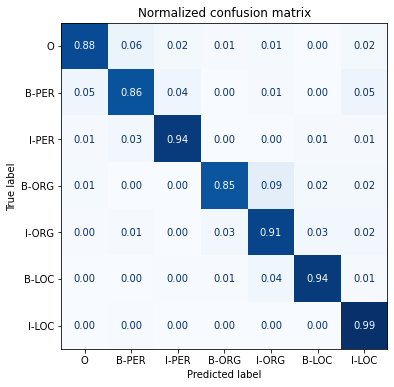

In [ ]:
## we can see the mmodel has problem identifying organizations
# see confusion matrix 
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt


def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"],
tags.names)

The model mainly mistakes B-ORG with I-ORG

In [ ]:
# inspect token sequence
def get_samples(df):                                                    
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []                  
        for i, mask in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])                         # Adding labels. 
                preds.append(row["predicted_label"][i])                 # Adding predicted labels.
                tokens.append(row["input_tokens"][i])                   # Adding tokens.
                losses.append(f"{row['loss'][i]:.2f}")                  # Adding loss.
        df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels,
                               "preds": preds, "losses": losses}).T      # Creating dataframe.
        yield df_tmp            


df["total_loss"] = df["loss"].apply(sum)                                # Adding loss.
df_tmp = df.sort_values(by="total_loss", ascending=False).head(5)       # Initializing dataframe.
for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,▁',▁'',▁Τ,Κ,▁'',▁',▁',▁'',▁T,▁'',▁',ri,▁'',▁',k,▁'',▁',ala,</s>
labels,O,O,O,IGN,O,O,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,IGN
preds,O,O,B-ORG,B-ORG,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O
losses,0.00,0.00,3.91,0.00,0.00,0.00,10.78,10.13,10.03,9.62,9.25,0.00,9.59,9.84,0.00,9.94,9.85,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
tokens,▁'',8,.,▁Juli,▁'',▁:,▁Protest,camp,▁auf,▁dem,▁Gelände,▁der,▁Republika,n,ischen,▁Gar,de,</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,IGN,I-ORG,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,O,O,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O
losses,7.72,0.00,0.00,5.89,8.04,8.60,6.70,0.00,8.27,8.74,7.71,6.00,2.92,0.00,0.00,0.01,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,▁United,▁Nations,▁Multi,dimensional,▁Integra,ted,▁Stabil,ization,▁Mission,▁in,▁the,▁Central,▁African,▁Republic,</s>
labels,B-PER,I-PER,I-PER,IGN,I-PER,IGN,I-PER,IGN,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,6.72,6.42,6.53,0.00,6.38,0.00,6.25,0.00,6.18,5.70,5.99,6.14,5.87,5.56,0.00


,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
tokens,▁Im,▁Jahr,▁2006,▁spielt,e,▁sie,▁in,▁einigen,▁Folgen,▁der,...,▁'',Bro,oke,▁'',▁über,nah,m,▁,.,</s>
labels,O,O,O,O,IGN,O,O,O,O,O,...,O,IGN,IGN,O,O,IGN,IGN,O,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O
losses,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,▁1988,▁in,▁Auckland,▁und,▁1989,▁in,▁Stavanger,▁tru,g,▁er,▁mit,▁einem,▁sie,b,ten,▁bzw,▁,.,</s>
labels,B-ORG,I-ORG,I-ORG,O,B-ORG,I-ORG,I-ORG,O,IGN,O,O,O,O,IGN,IGN,O,O,IGN,IGN
preds,O,O,B-LOC,O,O,O,B-LOC,O,O,O,O,O,O,O,O,O,O,O,O
losses,5.47,10.31,8.07,0.00,5.19,10.11,7.84,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


We can see from the above that some labels are wrong. This is because it was generated using a silver approach- automatic process. Also parentheses and slashes affect the model. In practice we wont include such in our dataset

In [ ]:
# see samples with opening brackets
df_tmp = df.loc[df["input_tokens"].apply(lambda x: u"\u2581(" in x)].head(2)
for sample in get_samples(df_tmp):
  display(sample)

,0,1,2,3,4,5
tokens,▁Ham,a,▁(,▁Unternehmen,▁),</s>
labels,B-ORG,IGN,I-ORG,I-ORG,I-ORG,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,0.01,0.00,0.02,0.01,0.02,0.00


,0,1,2,3,4,5,6,7
tokens,▁Kesk,kül,a,▁(,▁Mart,na,▁),</s>
labels,B-LOC,IGN,IGN,I-LOC,I-LOC,IGN,I-LOC,IGN
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC
losses,0.02,0.00,0.00,0.02,0.02,0.00,0.02,0.00


### Cross Lingual Transfer

#### Finetune On One Make Predictions On Others

In [ ]:
# function evaluates a model on test set
def get_f1_score(trainer, dataset):
  return trainer.predict(dataset).metrics['test_f1']

#apply function evaluate on de test set
f1_scores = defaultdict(dict) # default dict keeps track of f1 scores
f1_scores["de"]["de"] = get_f1_score(trainer, panx_de_encoded["test"])
print(f"F1-score of [de] model on [de] dataset: {f1_scores['de']['de']:.3f}")

F1-score of [de] model on [de] dataset: 0.865


Thats a great score score even though from error analysis, we saw our model had difficulty with recognizing organizations and also had some mislabelling.
lets see how this model finetuned on just german corpus perform on other languages

In [ ]:
# evaluate on a sample french set
text_fr = "Jeff Dean est informaticien chez Google en Californie"
tag_text(text_fr, tags, trainer.model, xlmr_tokenizer)

In [ ]:
# function evaluate on whole test set of any language
def evaluate_lang_performance(lang, trainer):
  panx_ds = encode_panx_dataset(panx_ch[lang])
  return get_f1_score(trainer, panx_ds["test"])

# see french performance
f1_scores["de"]["fr"] = evaluate_lang_performance("fr", trainer)
print(f"F1-score of [de] model on [fr] dataset: {f1_scores['de']['fr']:.3f}")

# see italian performance
f1_scores["de"]["it"] = evaluate_lang_performance("it", trainer)
print(f"F1-score of [de] model on [it] dataset: {f1_scores['de']['it']:.3f}")

# see english performance
f1_scores["de"]["en"] = evaluate_lang_performance("en", trainer)
print(f"F1-score of [de] model on [en] dataset: {f1_scores['de']['en']:.3f}")

We can see that performance depends on how far apart the languages are to each other. Although we see worst performance on the english corpus even though its closer to de than others. Lets examine when to finetune on the target language

#### Finetune on each and make prediction on each

In [ ]:
# Lets finetune on different subsets of french and see when it makes sense to 
# finetune on monolingual corpus


#function does the task described above
def train_on_subset(dataset,num_samples):
  train_ds = dataset["train"].shuffle(seed=42).select(range(num_samples))
  valid_ds = dataset["validation"]
  test_ds = dataset["test"]
  training_args.logging_steps = len(train_ds) // batch_size
  trainer = Trainer(model_init=model_init, args=training_args,
                    data_collator=data_collator, compute_metrics=compute_metrics,
                    train_dataset=train_ds, eval_dataset=valid_ds, tokenizer=xlmr_tokenizer)
  
  trainer.train()
  if training_args.push_to_hub:
    trainer.push_to_hub(commit_message="Training completed!")
  f1_score = get_f1_score(trainer, test_ds)
  return pd.DataFrame.from_dict({"num_samples": [len(train_ds)], "f1_score": [f1_score]})

# first encode the french texts
panx_fr_encoded = encode_panx_dataset(panx_ch["fr"])

# run function above on a 250 subset of french corpus
training_args.push_to_hub = False
metrics_df = train_on_subset(panx_fr_encoded, 250)
metrics_df

  0%|          | 0/5 [00:00<?, ?ba/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-bdd640fb06671ad1.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-3eb13b9046685257.arrow
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,F1
1,1.687000,1.221016,0.129006
2,1.126100,0.942918,0.313255
3,0.900700,0.845252,0.394050


,num_samples,f1_score
0,250,0.390639


Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-9b8df7a4aa0364b1.arrow
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,F1
1,1.406800,0.931262,0.304701
2,0.757900,0.524862,0.641636
3,0.449700,0.452001,0.701425


Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-9b8df7a4aa0364b1.arrow


Epoch,Training Loss,Validation Loss,F1
1,1.037700,0.470037,0.702128
2,0.374400,0.392393,0.750326
3,0.256200,0.380170,0.776971


Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-9b8df7a4aa0364b1.arrow


Epoch,Training Loss,Validation Loss,F1
1,0.731200,0.398479,0.744547
2,0.308800,0.340194,0.781564
3,0.192900,0.336407,0.817484


Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-9b8df7a4aa0364b1.arrow


Epoch,Training Loss,Validation Loss,F1
1,0.582000,0.320605,0.795599
2,0.269500,0.282946,0.823372


Epoch,Training Loss,Validation Loss,F1
1,0.582000,0.320605,0.795599
2,0.269500,0.282946,0.823372
3,0.174800,0.294977,0.835545


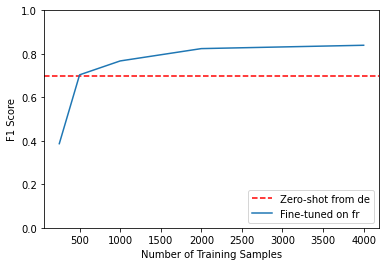

In [ ]:
# seeing perfomance on 250 is bad, increase subsets and compare

torch.cuda.empty_cache() # empty cache

for num_samples in [500, 1000, 2000, 4000]:
  metrics_df = metrics_df.append(train_on_subset(panx_fr_encoded, num_samples), ignore_index=True)

# plot results
fig, ax = plt.subplots()
ax.axhline(f1_scores["de"]["fr"], ls="--", color="r")
metrics_df.set_index("num_samples").plot(ax=ax)
plt.legend(["Zero-shot from de", "Fine-tuned on fr"], loc="lower right")
plt.ylim((0, 1))
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.show()

#### Fine-Tuning on Multiple Languages at Once

In [ ]:
from datasets import concatenate_datasets  # concat multi_language data

torch.cuda.empty_cache() # empty cache
# function to concat multi langauages
def concatenate_splits(corpora):
  multi_corpus = DatasetDict()   # initailize dataset dictionary
  for split in corpora[0].keys():
    multi_corpus[split] = concatenate_datasets([corpus[split] for corpus in corpora]).shuffle(seed=42)
  return multi_corpus

# concat de and fr
panx_de_fr_encoded = concatenate_splits([panx_de_encoded, panx_fr_encoded])

# train model
training_args.logging_steps = len(panx_de_fr_encoded["train"]) // batch_size
training_args.push_to_hub = True
training_args.output_dir = "xlm-roberta-base-finetuned-panx-de-fr"
trainer = Trainer(model_init=model_init, args=training_args,
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  tokenizer=xlmr_tokenizer, train_dataset=panx_de_fr_encoded["train"],
                  eval_dataset=panx_de_fr_encoded["validation"])

trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

# see performance on each test set
for lang in langs:
  f1 = evaluate_lang_performance(lang, trainer)
  print(f"F1-score of [de-fr] model on [{lang}] dataset: {f1:.3f}")

Cloning https://huggingface.co/okite97/xlm-roberta-base-finetuned-panx-de-fr into local empty directory.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,F1
1,0.283700,0.177490,0.837922


Epoch,Training Loss,Validation Loss,F1
1,0.283700,0.177490,0.837922
2,0.144600,0.130117,0.876699
3,0.091700,0.119620,0.897346


Adding files tracked by Git LFS: ['tokenizer.json']. This may take a bit of time if the files are large.


Upload file pytorch_model.bin:   0%|          | 3.33k/1.03G [00:00<?, ?B/s]

Upload file tokenizer.json:   0%|          | 3.34k/16.3M [00:00<?, ?B/s]

Upload file training_args.bin: 100%|##########| 3.30k/3.30k [00:00<?, ?B/s]

To https://huggingface.co/okite97/xlm-roberta-base-finetuned-panx-de-fr
   00e20bc..161be5f  main -> main

To https://huggingface.co/okite97/xlm-roberta-base-finetuned-panx-de-fr
   161be5f..97ed8a3  main -> main

Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-1c80317fa3b1799d.arrow


  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-23b8c1e9392456de.arrow


F1-score of [de-fr] model on [de] dataset: 0.867


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-8b9d2434e465e150.arrow


F1-score of [de-fr] model on [fr] dataset: 0.863


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-17fc695a07a0ca6e.arrow


F1-score of [de-fr] model on [it] dataset: 0.807


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

F1-score of [de-fr] model on [en] dataset: 0.679


Here we see performance increases for individual languages showing that adding more dataset of one language increases performance on all other languages

In [ ]:
# see how finetuning separating on each language compares to multilingual learning

torch.cuda.empty_cache() # empty cache

corpora = [panx_de_encoded]

for lang in langs[1:]:    # Exclude German from iteration
  training_args.output_dir = f"xlm-roberta-base-finetuned-panx-{lang}"
  ds_encoded = encode_panx_dataset(panx_ch[lang])  # Fine-tune on monolingual corpus
  metrics = train_on_subset(ds_encoded, ds_encoded["train"].num_rows)
  f1_scores[lang][lang] = metrics["f1_score"][0]   # Collect F1-scores in common dict
  corpora.append(ds_encoded)   # Add monolingual corpus to list of corpora to concatenate


corpora_encoded = concatenate_splits(corpora)   # concat across all 4 languages
training_args.logging_steps = len(corpora_encoded["train"]) // batch_size  # update logging
training_args.output_dir = "xlm-roberta-base-finetuned-panx-all"   # output_dir of new model

#initialize new trainer
trainer = Trainer(model_init=model_init, args=training_args,
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  tokenizer=xlmr_tokenizer, train_dataset=corpora_encoded["train"],
                  eval_dataset=corpora_encoded["validation"])

trainer.train()   # train
trainer.push_to_hub(commit_message="Training completed!")  # push model to hub

for idx, lang in enumerate(langs):
  f1_scores["all"][lang] = get_f1_score(trainer, corpora[idx]["test"])

scores_data = {"de": f1_scores["de"],
               "each": {lang: f1_scores[lang][lang] for lang in langs},
               "all": f1_scores["all"]}

f1_scores_df = pd.DataFrame(scores_data).T.round(4)
f1_scores_df.rename_axis(index="Fine-tune on", columns="Evaluated on",inplace=True)
f1_scores_df   # show results

Loading cached processed dataset at /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/349258adc25bb45e47de193222f95e68a44f7a7ab53c4283b3f007208a11bf7e/cache-8fadc1a606cb0fb3.arrow


  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

Cloning https://huggingface.co/okite97/xlm-roberta-base-finetuned-panx-fr into local empty directory.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,F1
1,0.699500,0.392237,0.731667
2,0.322200,0.337200,0.795771
3,0.208000,0.339023,0.809109


Adding files tracked by Git LFS: ['tokenizer.json']. This may take a bit of time if the files are large.


Upload file pytorch_model.bin:   0%|          | 3.33k/1.03G [00:00<?, ?B/s]

Upload file tokenizer.json:   0%|          | 3.34k/16.3M [00:00<?, ?B/s]

Upload file training_args.bin: 100%|##########| 3.30k/3.30k [00:00<?, ?B/s]

To https://huggingface.co/okite97/xlm-roberta-base-finetuned-panx-fr
   aa5753c..6ff1b37  main -> main

To https://huggingface.co/okite97/xlm-roberta-base-finetuned-panx-fr
   6ff1b37..90d4965  main -> main



  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Cloning https://huggingface.co/okite97/xlm-roberta-base-finetuned-panx-it into local empty directory.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,F1
1,0.668000,0.288556,0.781759
2,0.258300,0.242057,0.820179
3,0.168200,0.240330,0.828947


Adding files tracked by Git LFS: ['tokenizer.json']. This may take a bit of time if the files are large.


Upload file pytorch_model.bin:   0%|          | 3.33k/1.03G [00:00<?, ?B/s]

Upload file tokenizer.json:   0%|          | 3.34k/16.3M [00:00<?, ?B/s]

Upload file training_args.bin: 100%|##########| 3.30k/3.30k [00:00<?, ?B/s]

To https://huggingface.co/okite97/xlm-roberta-base-finetuned-panx-it
   8cfc64a..e77b6a2  main -> main

To https://huggingface.co/okite97/xlm-roberta-base-finetuned-panx-it
   e77b6a2..26cc6a3  main -> main



  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Cloning https://huggingface.co/okite97/xlm-roberta-base-finetuned-panx-en into local empty directory.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,F1
1,1.043500,0.516917,0.553191
2,0.471900,0.422413,0.662983
3,0.342400,0.384815,0.699448


Adding files tracked by Git LFS: ['tokenizer.json']. This may take a bit of time if the files are large.


Upload file pytorch_model.bin:   0%|          | 3.33k/1.03G [00:00<?, ?B/s]

Upload file training_args.bin: 100%|##########| 3.30k/3.30k [00:00<?, ?B/s]

Upload file tokenizer.json:   0%|          | 3.34k/16.3M [00:00<?, ?B/s]

To https://huggingface.co/okite97/xlm-roberta-base-finetuned-panx-en
   aa2931d..d7d1acc  main -> main

To https://huggingface.co/okite97/xlm-roberta-base-finetuned-panx-en
   d7d1acc..d5d6b64  main -> main



Cloning https://huggingface.co/okite97/xlm-roberta-base-finetuned-panx-all into local empty directory.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,F1
1,0.296700,0.204957,0.817979
2,0.157100,0.188048,0.841503
3,0.098300,0.188258,0.853819


Adding files tracked by Git LFS: ['tokenizer.json']. This may take a bit of time if the files are large.


Upload file pytorch_model.bin:   0%|          | 3.33k/1.03G [00:00<?, ?B/s]

Upload file tokenizer.json:   0%|          | 3.34k/16.3M [00:00<?, ?B/s]

Upload file training_args.bin: 100%|##########| 3.30k/3.30k [00:00<?, ?B/s]

To https://huggingface.co/okite97/xlm-roberta-base-finetuned-panx-all
   8103bfc..54799de  main -> main

To https://huggingface.co/okite97/xlm-roberta-base-finetuned-panx-all
   54799de..1bc0865  main -> main



Evaluated on,de,fr,it,en
Fine-tune on,,,,
de,0.8647,0.6975,0.6572,0.5916
each,0.8647,0.9214,0.8328,0.7112
all,0.8706,0.9394,0.8638,0.7628


## Summary

From this chapter,I learnt about Multilingual transformers, how to build a task specific head on custom tasks, steps  in tokenization, why Sentencepiece is used instead of WordPiece for Multilingual transfer learning, Dataset preparation NER. 

I also verified that the approach of finetuning on a multilingual task will depend on availability of data and cost of getting label examples of low resource languages, consequently good performances occur when the lanuages are closer to each other.